# Sentiment Analysis of Consumer Reviews of Amazon Products

In [ ]:
from transformers import pipeline
from transformers import TrainingArguments, Trainer

In [ ]:
!pip install datasets

In [ ]:
!pip install datasets evaluate

In [ ]:
!pip install evaluate==0.4.0

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%run "/content/drive/MyDrive/llm/Emoticon.py"

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import seaborn as sns
import pandas as pd
pd.options.display.max_colwidth = 300
from sklearn.utils import class_weight
import numpy as np
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from transformers import AutoModelForSequenceClassification
from datasets import Dataset
#from datasets import load_metric
from evaluate import load #load_metric -- old version
import sys
sys.path.append('/content/drive/MyDrive/llm/')
from Emoticon import EMOTICONS_EMO
from sklearn.utils import shuffle
import torch
from torch import nn
from transformers import DataCollatorWithPadding

In [ ]:
 EMOTICONS_EMO

{':‑)': 'Happy face or smiley',
 ':-))': 'Very happy',
 ':-)))': 'Very very Happy face or smiley',
 ':)': 'Happy face or smiley',
 ':))': 'Very Happy face or smiley',
 ':)))': 'Very very Happy face or smiley',
 ':-]': 'Happy face or smiley',
 ':]': 'Happy face or smiley',
 ':-3': 'Happy face smiley',
 ':3': 'Happy face smiley',
 ':->': 'Happy face smiley',
 ':>': 'Happy face smiley',
 '8-)': 'Happy face smiley',
 ':o)': 'Happy face smiley',
 ':-}': 'Happy face smiley',
 ':}': 'Happy face smiley',
 ':-)': 'Happy face smiley',
 ':c)': 'Happy face smiley',
 ':^)': 'Happy face smiley',
 '=]': 'Happy face smiley',
 '=)': 'Happy face smiley',
 ':‑D': 'Laughing, big grin or laugh with glasses',
 ':D': 'Laughing, big grin or laugh with glasses',
 '8‑D': 'Laughing, big grin or laugh with glasses',
 '8D': 'Laughing, big grin or laugh with glasses',
 'X‑D': 'Laughing, big grin or laugh with glasses',
 'XD': 'Laughing, big grin or laugh with glasses',
 '=D': 'Laughing, big grin or laugh with glass

### Data Description

For this project I used the data provided by Kaggle [Consumer Reviews of Amazon Products](
https://www.kaggle.com/datasets/datafiniti/consumer-reviews-of-amazon-products). The dataset includes rating, review text, category, timestamp etc. for each product.



## Helper Functions

In [ ]:
def create_sentiment(row):
    """ Convert rating to setiment
    Input:
        pandas Series row
    Output
        pandas Series row


    """
    if row >= 4:
        sentiment = 1
    else:
        sentiment = 0
    return sentiment

In [ ]:
def convert_predictions(row):
    """ Convert predicted sentiment to nummeric output
    Input:
        pandas Series row
    Output
        pandas Series row


    """
    if row[0]["label"]=='POSITIVE':
        sentiment = 1
    elif row[0]["label"]=='NEGATIVE':
        sentiment = 0
    else:
        sentiment = np.nan
    return sentiment

## 1. Data cleaning

In [ ]:
# df = pd.read_csv("Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv",low_memory=False)

In [ ]:
from google.colab import drive
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

# Construct the path to the CSV file in your Google Drive
csv_file_path = '/content/drive/MyDrive/llm/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv'  # Replace with your file's path in Drive

# Read the CSV file
df = pd.read_csv(csv_file_path, low_memory=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df.head(8)

,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,...,reviews.didPurchase,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs
0,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batteries (36 Count),"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,Camcorder Batteries,Camera & Photo,Batteries,Household Batteries,Robot Check,Accessories,Camera Batteries,Health and Beauty,Household Supplies,Batteries & Chargers,Health, Household & Baby Care,Health Personal Care",Health & Beauty,"https://images-na.ssl-images-amazon.com/images/I/81qmNyJo%2BkL._SL1500_.jpg,https://images-na.ssl-images-amazon.com/images/I/81ZTa1BrkzL._SL1500_.jpg,http://ecx.images-amazon.com/images/I/41pSoRu7UlL._SS40_.jpg,https://www.upccodesearch.com/images/barcode/0841710106442.png,https://images-na.ssl-...","amazonbasics/hl002619,amazonbasicsaaaperformancealkalinebatteries36count/b00lh3dmuo,0841710106442,841710106442,amazonbasicsaaaperformancealkalinebatteries36count/b00qwo9p0o",...,NaN,NaN,NaN,NaN,3,https://www.amazon.com/product-reviews/B00QWO9P0O/,I order 3 of them and one of the item is bad quality. Is missing backup spring so I have to put a pcs of aluminum to make the battery work.,... 3 of them and one of the item is bad quality. Is missing backup spring so I have ...,Byger yang,"https://www.barcodable.com/upc/841710106442,https://www.amazon.com/AmazonBasics-Performance-Alkaline-Batteries-Count/dp/B00LH3DMUO/,https://www.amazon.com/AmazonBasics-Performance-Alkaline-Batteries-Count/dp/B00LH3DMUO,https://www.amazon.com/AmazonBasics-Performance-Alkaline-Batteries-36-Pack/dp..."
1,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batteries (36 Count),"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,Camcorder Batteries,Camera & Photo,Batteries,Household Batteries,Robot Check,Accessories,Camera Batteries,Health and Beauty,Household Supplies,Batteries & Chargers,Health, Household & Baby Care,Health Personal Care",Health & Beauty,"https://images-na.ssl-images-amazon.com/images/I/81qmNyJo%2BkL._SL1500_.jpg,https://images-na.ssl-images-amazon.com/images/I/81ZTa1BrkzL._SL1500_.jpg,http://ecx.images-amazon.com/images/I/41pSoRu7UlL._SS40_.jpg,https://www.upccodesearch.com/images/barcode/0841710106442.png,https://images-na.ssl-...","amazonbasics/hl002619,amazonbasicsaaaperformancealkalinebatteries36count/b00lh3dmuo,0841710106442,841710106442,amazonbasicsaaaperformancealkalinebatteries36count/b00qwo9p0o",...,NaN,NaN,NaN,NaN,4,https://www.amazon.com/product-reviews/B00QWO9P0O/,Bulk is always the less expensive way to go for products like these,... always the less expensive way to go for products like,ByMG,"https://www.barcodable.com/upc/841710106442,https://www.amazon.com/AmazonBasics-Performance-Alkaline-Batteries-Count/dp/B00LH3DMUO/,https://www.amazon.com/AmazonBasics-Performance-Alkaline-Batteries-Count/dp/B00LH3DMUO,https://www.amazon.com/AmazonBasics-Performance-Alkaline-Batteries-36-Pack/dp..."
2,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batteries (36 Count),"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,Camcorder Batteries,Camera & Photo,Batteries,Household Batteries,Robot Check,Accessories,Camera Batteries,Health and Beauty,Household Supplies,Batteries & Chargers,Health, Household & Baby Care,Health Personal Care",Health & Beauty,"https://images-na.ssl-images-amazon.com/images/I/81qmNyJo%2BkL._SL1500_.jpg,https://images-na.ssl-images-amazon.com/images/I/81ZTa1BrkzL._SL1500_.jpg,http://ecx.images-amazon.com/images/I/41pSoRu7UlL._SS40_.jpg,https://www.upccodesearch.com/images/barcode/0841710106442.png,https://images-na.ssl-...","amazonbasics/hl002619,amazonbasicsaaaperformancealkalin

In [ ]:
df.columns

Index(['id', 'dateAdded', 'dateUpdated', 'name', 'asins', 'brand',
       'categories', 'primaryCategories', 'imageURLs', 'keys', 'manufacturer',
       'manufacturerNumber', 'reviews.date', 'reviews.dateSeen',
       'reviews.didPurchase', 'reviews.doRecommend', 'reviews.id',
       'reviews.numHelpful', 'reviews.rating', 'reviews.sourceURLs',
       'reviews.text', 'reviews.title', 'reviews.username', 'sourceURLs'],
      dtype='object')

In [ ]:
df['categories'].unique()

array(['AA,AAA,Health,Electronics,Health & Household,Camcorder Batteries,Camera & Photo,Batteries,Household Batteries,Robot Check,Accessories,Camera Batteries,Health and Beauty,Household Supplies,Batteries & Chargers,Health, Household & Baby Care,Health Personal Care',
       'Audio & Video Accessories,TV, Video & Home Audio,Home Audio & Video Accessories,DVD Cases,Electronics,Media Cases & Storage,TV, Video & Audio Accessories,Media Storage & Organization,Disc Storage Wallets,Consumer Electronics,CD, DVD & Blu-ray Discs,Blank Audio/Video Media,Accessories & Supplies,all electronics',
       'Stereos,Remote Controls,Audio Docks & Mini Speakers,Kitchen & Dining Features,Home & Tools,Electronics,New Networking,Wireless Speakers,Home, Garage & Office,Portable Speakers,iPod, Audio Player Accessories,Smart Home,Surveillance,Home Improvement,Smart Home & Home Automation Devices,Alarms & Sensors,Amazon Devices,Amazon,Holiday Shop,Kitchen Dining Features,Amazon Echo,Amazon Echo Accessories,Net

In [ ]:
# remove empty reviews and rating
df = df[(df['reviews.text'].isnull()==False)&(df['reviews.rating'].isnull()==False)]

In [ ]:
df.shape

(28332, 24)

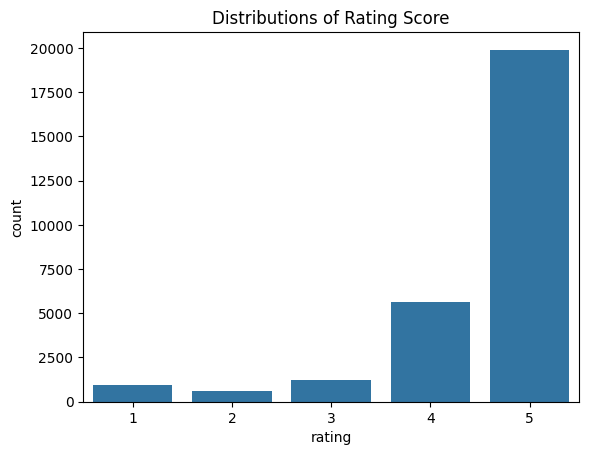

In [ ]:
sns.countplot(data=df, x="reviews.rating")
plt.xlabel('rating');
plt.title("Distributions of Rating Score");

Turning to the graphic, it shows the scores from minimal 1 and maximum 5.
Interesting is that the data has a lot of better score (4-5) and less negative (1-3)

In [ ]:
# convert rating to sentiment classes (positive and negative)
df.loc[:,'label'] = df['reviews.rating'].apply(create_sentiment)

In [ ]:
df = df[['reviews.text','label']]

In [ ]:
df.rename(columns={'reviews.text': "text"},inplace=True)

In [ ]:
# remove duplicates
df.drop_duplicates(subset=['text'], keep='last', inplace=True)

In [ ]:
df.shape

(18168, 2)

The text in comments is quite clean without html tags and with very few links. So for that reason, I will only convert emojis to text. In addition, for data Data augmentation (Section 3) I will use the technique of back translation. Therefore, I will not lowercase the text.

In [ ]:
def convert_emoticons_to_words(row):
    """ Convert emojis in comments into text
    Input:
        pandas Series row
    Output
        pandas Series row


    """
    for i, j in EMOTICONS_EMO.items():
        row = row.replace(i, j)
    return row


In [ ]:
df['text'] = df['text'].apply(convert_emoticons_to_words)

In [ ]:
def visualize_class_distribution(data):
    """
    Visualisation of the proportions
    for each class
    Input:
        data: pandas dataframe
    Output:
        None

    """
    colors = ['royalblue', 'pink']
    fig, ax = plt.subplots()
    ax.pie(data['label'].value_counts(), labels=["positive","negative"], autopct='%1.1f%%', colors=colors)
    plt.title("Sentiment Class Distribution");


The graph below makes it clear that the class of negative reviews is disproportionally underrepresented. This challenge will be handled in the section "3. Data augmentation" and "5. Data balancing"

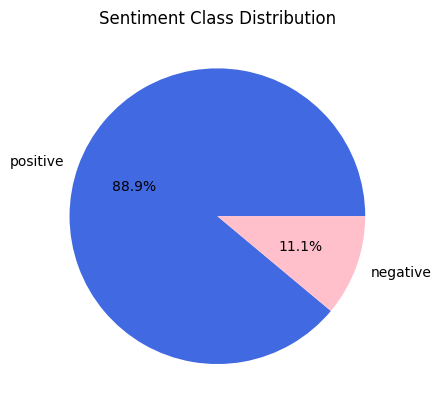

In [ ]:
visualize_class_distribution(df)

## 2. Data splitting

In [ ]:
# splitting dataset into training(60%), validation(20%) and test set (20%)
train, validate, test = \
              np.split(df.sample(frac=1, random_state=42),
                       [int(.6*len(df)), int(.8*len(df))])

/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


## Using Basic "sentiment-roberta-large-english" Model

As the baseline I use [SiEBERT - English-Language Sentiment Classification](https://huggingface.co/siebert/sentiment-roberta-large-english) model which enables to predict positive and negative sentiment. The model is a fine-tuned checkpoint of RoBERTa-large (Liu et al. 2019) and outperformed DistilBERT SST-2
on average by  15 p.p. (78.1 vs 93.2)


In [ ]:
roberta_classifier = pipeline("sentiment-analysis",model="siebert/sentiment-roberta-large-english",truncation = True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Device set to use cuda:0


In [ ]:
def get_predictions(data_test, classifier):
    """
    Create new column with predictions
    Input:
        data_test: DataFrame
    Output:
        data_test: DataFrame (with predictions)
    """
    data_test['roberta_sentiment'] = data_test['text'].apply(lambda x : classifier(x))
    data_test.loc[:,'predicted'] =data_test["roberta_sentiment"].apply(convert_predictions)
    return data_test

In [ ]:
test_basis = test.copy()

In [ ]:
test_basis_prediction = get_predictions(test_basis, roberta_classifier)

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [ ]:
print(classification_report(test_basis_prediction.label, test_basis_prediction.predicted))

              precision    recall  f1-score   support

           0       0.69      0.78      0.73       396
           1       0.97      0.96      0.96      3238

    accuracy                           0.94      3634
   macro avg       0.83      0.87      0.85      3634
weighted avg       0.94      0.94      0.94      3634



In [ ]:
# check if there are any unpredicted comments
test_basis_prediction[test_basis_prediction.predicted.isnull()==True]

,text,label,roberta_sentiment,predicted


## Fine-tuning model

## 3. Data augmentation

For data augmentation I will use the technique [“Back Translation”](https://towardsdatascience.com/nlp-data-augmentation-using-transformers-89a44a993bab).  First of all, I translate the English text into German and then back to English. The major reasons for this technique are
1.	There are enough good performing models for English
2.	Due to the fact, that the task is sentiment analysis (the polarity of the sentences). I don’t want to add noise to the dataset with random replacement, random insertion or text generation etc.
3. With Back Translation we will create new samples for the minority class (oversampling)


In [ ]:
#English to German
translation_en_to_de = pipeline("translation_en_to_de", model='t5-base')

#Germal to English
tokenizer = AutoTokenizer.from_pretrained("google/bert2bert_L-24_wmt_de_en", pad_token="<pad>", eos_token="</s>", bos_token="<s>")
model_de_to_en = AutoModelForSeq2SeqLM.from_pretrained("google/bert2bert_L-24_wmt_de_en")


In [ ]:
def back_translation(input_text):
    """ Translate the text from English to German
        and then from German to English
    Input:
        pandas Series row
    Output
        pandas Series row


    """
    review_en_to_de = translation_en_to_de(input_text)
    text_en_to_de = review_en_to_de[0]['translation_text']
    input_ids = tokenizer(text_en_to_de, return_tensors="pt", add_special_tokens=False,max_length=512,truncation=True).input_ids
    output_ids = model_de_to_en.generate(input_ids)[0]
    augmented_review = tokenizer.decode(output_ids, skip_special_tokens=True)
    return augmented_review

In [ ]:
def create_data_samples(data):
    """
    Create new samples for training
    Input:
        data: pandas data frame
    Output:
        data: pandas data frame with additional sampels

    """
    count_labels= data["label"].value_counts()
    n = count_labels[1]-count_labels[0]
    # oversampling for negative class
    data_temp = data[data.label==0].sample(n=n, replace=True, random_state=1)
    data_temp.loc[:,'samples'] =data_temp["text"].apply(back_translation)
    data_temp = data_temp.drop('text', axis=1)
    data_temp.rename(columns={'samples': "text"},inplace=True)
    data_sampled = pd.concat([data_temp, data], ignore_index=True)
    data_sampled = shuffle(data_sampled, random_state=0)
    return data_sampled


In [ ]:
train = create_data_samples(train)

Looking at the graph below you can see, that now the training dataset is balanced. This dataset will be used for the second approach (Data Balancing - Oversampling)  

In [ ]:
visualize_class_distribution(train)

In [ ]:
train.shape

## 4. Data preprocessing

One of the parameter of tokenizer is max_length. So, before I use default number, let us check, what is the max number of the reviews


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("siebert/sentiment-roberta-large-english")

In [ ]:
train = Dataset.from_pandas(train).remove_columns(['__index_level_0__'])
validate = Dataset.from_pandas(validate).remove_columns(['__index_level_0__'])
test = Dataset.from_pandas(test).remove_columns(['__index_level_0__'])

In [ ]:
def get_review_len(data):
    """
    Calculate the length of each sentence
    Input:
        data: Dataset
    Output:
        tokens_len: list with length of each sentence

    """
    tokens_len = []
    for review in data["text"]:
        tokens = tokenizer.encode(review)
        tokens_len.append(len(tokens))
    return tokens_len

In [ ]:
# max number of tokens
np.array(get_review_len(train)).max()

Token indices sequence length is longer than the specified maximum sequence length for this model (563 > 512). Running this sequence through the model will result in indexing errors


1173

In [ ]:
# min number of tokens
np.array(get_review_len(train)).min()

3

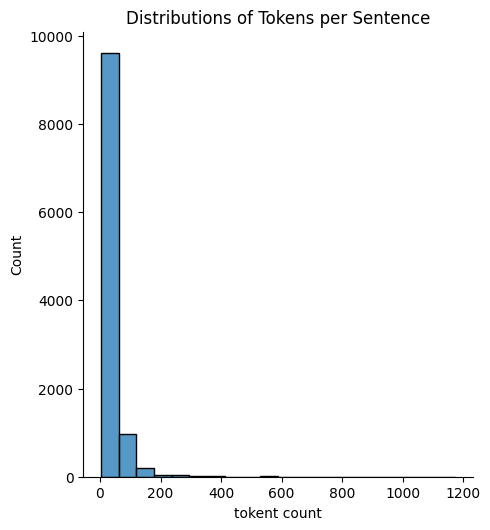

In [ ]:
sns.displot(get_review_len(train),bins=20)
plt.xlabel('tokent count');
plt.title("Distributions of Tokens per Sentence");


The graph above makes it clear that the most of the review are below 180 tokens. For that reason, I will set max_lenght to 180

In [ ]:
def preprocess_function(data):
    """
    Input data: Dataset
    Output: data: Dataset: with 'input_ids' and 'attention_mask'

    """
    return tokenizer(data['text'], padding="max_length", max_length=180,truncation=True)

In [ ]:
tokenized_train = train.map(preprocess_function, batched=True)
tokenized_val= validate.map(preprocess_function, batched=True)

Map:   0%|          | 0/10900 [00:00<?, ? examples/s]

Map:   0%|          | 0/3634 [00:00<?, ? examples/s]

In [ ]:
#In order to speed up the training, the training samples will be converted to Pytorch tensors
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("siebert/sentiment-roberta-large-english", num_labels=2)

For the evaluation of the model performance, I will use on the one hand, accuracy, on the other hand f1 score (as we have an imbalanced dataset). In comparison to accuracy, the f1-score pays more attention to false negative and false positive predictions

In [ ]:
def compute_metrics(eval_pred):
    """
    Defines the evaluation metrics for fine-tuned model

    """
    load_accuracy = load_metric("accuracy")
    load_f1 = load_metric("f1")

    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
    f1 = load_f1.compute(predictions=predictions, references=labels)["f1"]

    print("eval_pred", type(eval_pred))
    print("accuracy", type(accuracy),accuracy)
    print("f1", type(f1),f1)
    return {"accuracy": accuracy, "f1": f1}


## 5. Data balancing

Since the dataset is imbalanced, I will test two approaches
1. I will integrate the weighted loss into the [Trainer](https://huggingface.co/docs/transformers/main_classes/trainer). Usually, the data points from each class are treated the same. That means,  that the model will learn more for the class which is overrepresented in the dataset. In order to overcome this issue, the weights for minority classes will be increased. This behavior will increase the loss as well and so force the model to pay more attention to these samples.
2. Random oversampling the minority of class through Back Translation (see function create_data_samples). In this case, the "CLASS_WEIGHTS" will be balanced and so have no substational impact on CrossEntropyLoss

In [ ]:
CLASS_WEIGHTS=class_weight.compute_class_weight('balanced',classes=np.unique(train["label"]),y=train["label"])
CLASS_WEIGHTS = torch.tensor(CLASS_WEIGHTS, dtype=torch.float).to("cuda") # Changed line


In [ ]:
CLASS_WEIGHTS

tensor([4.4201, 0.5638], device='cuda:0')

In [ ]:
import torch
from torch import nn
from transformers import Trainer

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        """
        Custom compute_loss function to incorporate CLASS_WEIGHTS
        """
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get('logits')
        # compute custom loss
        # Ensure CLASS_WEIGHTS is on the same device as the logits and labels
        loss_fct = nn.CrossEntropyLoss(weight=CLASS_WEIGHTS.to(logits.device), reduction='mean') # Changed line
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [ ]:
# class CustomTrainer(Trainer):
#     def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
#         labels = inputs.get("labels")
#         # forward pass
#         outputs = model(**inputs)
#         logits = outputs.get('logits')
#         # compute custom loss
#         loss_fct = nn.CrossEntropyLoss(weight=CLASS_WEIGHTS,reduction='mean')
#         loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
#         return (loss, outputs) if return_outputs else loss

In [ ]:
training_args = TrainingArguments(
   output_dir="finetuning-sentiment-roberta-large-english",
   learning_rate=2e-5,
   per_device_train_batch_size=8,
   per_device_eval_batch_size=8,
   num_train_epochs=2,
   optim = "adamw_torch",
   save_strategy="epoch",
   #use_mps_device="mps",
   no_cuda=False,
   warmup_steps = 500,
   weight_decay = 0.01,
   gradient_accumulation_steps = 2,
   fp16 = True,
   gradient_checkpointing = True
)

In [ ]:
trainer = CustomTrainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_train,
   eval_dataset=tokenized_val,
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics
)

<ipython-input-66-078c40bf8fa8>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(


In [ ]:
trainer.train()

OutOfMemoryError: CUDA out of memory. Tried to allocate 16.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 11.06 MiB is free. Process 53674 has 14.73 GiB memory in use. Of the allocated memory 14.40 GiB is allocated by PyTorch, and 208.07 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
trainer.evaluate()

NameError: name 'trainer' is not defined

In [ ]:
trainer.save_model("sentiment-roberta-large-english-fine-tuned")

In [ ]:
sentiment_model_fine_tuned =  pipeline("sentiment-analysis",model="sentiment-roberta-large-english-fine-tuned",truncation = True)

In [ ]:
test_fine_tuned_prediction = get_predictions(test_basis, sentiment_model_fine_tuned)

In [ ]:
print(classification_report(test_fine_tuned_prediction.label, test_fine_tuned_prediction.predicted))

In [ ]:
# check if there are any unpredicted comments
test_fine_tuned_prediction[test_fine_tuned_prediction.predicted.isnull()==True]

## Summary

As shown above the dataset was imbalanced. For this reason, I tested two approaches:
1.	Estimated the weights for imbalanced dataset and forwarded them to the CrossEntropyLoss(). The argument “weight” has impact on the importance of each class


                 precision    recall  f1-score   support

           0       0.69      0.53      0.60        45
           1       0.98      0.99      0.98       832

    accuracy                            0.96       877
    macro avg       0.83      0.76      0.79       877
    weighted avg    0.96      0.96      0.96       877



2. Random oversampling  the minority of class through Back Translation

                   precision    recall  f1-score   support

           0       0.54      0.49      0.51        45
           1       0.97      0.98      0.97       832

    accuracy                            0.95       877
    macro avg       0.75      0.73      0.74       877
    weighted avg    0.95      0.95      0.95       877



Overall our sentiment analysis shows, that estimation of the weights for imbalanced dataset has more impact on the f-score for negative class and improved the model performance compared to the baseline by 0.03 for negative class and by 0.01 for positive.

Furthermore, the technique used was to help us to compare the three models namely: oversampling, weights estimation and baseline. In result, we can observe the decrease of the f1-score for negative examples (oversampling) by 0.09 compared to weights estimation and by 0.06 compared to baseline model.  Noticeably, the model has challenges to generalize on the test set and considerable increased the training time.